In [1]:
import dlib
print(dlib.__version__)


19.24.2


In [2]:
import cv2
print(cv2.__version__)


4.11.0


In [3]:
import os
print(os.path.exists("shape_predictor_68_face_landmarks.dat"))  # Should return True


True


In [ ]:
import dlib
import cv2

detector = dlib.get_frontal_face_detector()

cap = cv2.VideoCapture(0)  # Open webcam

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    for face in faces:
        x, y, w, h = (face.left(), face.top(), face.width(), face.height())
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    cv2.imshow("Face Detection", frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [4]:

predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
import dlib
import cv2

# Load face detector & landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

cap = cv2.VideoCapture(0)  # Open webcam

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    for face in faces:
        landmarks = predictor(gray, face)

        for i in range(68):  # 68 landmark points
            x, y = landmarks.part(i).x, landmarks.part(i).y
            cv2.circle(frame, (x, y), 1, (0, 255, 0), -1)  # Draw small green dots

    cv2.imshow("Facial Landmark Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
import dlib
import cv2
import numpy as np

# Load models
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")  

# Reference Standard
reference_embedding = {
    "eyes": {"left_eye_width": 40, "right_eye_width": 40, "eye_distance": 80},
    "eyebrows": {"left_eyebrow_height": 20, "right_eyebrow_height": 20, "eyebrow_distance": 50},
    "mouth": {"mouth_width": 50, "mouth_height": 20}
}

cap = cv2.VideoCapture(0)  # Open webcam

# Open a text file to save data
with open("face_ratios.txt", "w") as file:
    file.write("Frame, Left Eye Width, Right Eye Width, Eye Distance, Left Eyebrow Height, Right Eyebrow Height, Eyebrow Distance, Mouth Width, Mouth Height\n")

def compute_embedding(landmarks):
    """Extract key distances from facial landmarks"""
    # Eyes
    left_eye_width = np.linalg.norm(np.array([landmarks.part(39).x, landmarks.part(39).y]) - 
                                    np.array([landmarks.part(36).x, landmarks.part(36).y]))
    right_eye_width = np.linalg.norm(np.array([landmarks.part(45).x, landmarks.part(45).y]) - 
                                     np.array([landmarks.part(42).x, landmarks.part(42).y]))
    eye_distance = np.linalg.norm(np.array([landmarks.part(42).x, landmarks.part(42).y]) - 
                                  np.array([landmarks.part(39).x, landmarks.part(39).y]))

    # Eyebrows
    left_eyebrow_height = np.linalg.norm(np.array([landmarks.part(21).x, landmarks.part(21).y]) - 
                                         np.array([landmarks.part(39).x, landmarks.part(39).y]))
    right_eyebrow_height = np.linalg.norm(np.array([landmarks.part(22).x, landmarks.part(22).y]) - 
                                          np.array([landmarks.part(42).x, landmarks.part(42).y]))
    eyebrow_distance = np.linalg.norm(np.array([landmarks.part(22).x, landmarks.part(22).y]) - 
                                      np.array([landmarks.part(21).x, landmarks.part(21).y]))

    # Mouth
    mouth_width = np.linalg.norm(np.array([landmarks.part(54).x, landmarks.part(54).y]) - 
                                 np.array([landmarks.part(48).x, landmarks.part(48).y]))
    mouth_height = np.linalg.norm(np.array([landmarks.part(66).x, landmarks.part(66).y]) - 
                                  np.array([landmarks.part(62).x, landmarks.part(62).y]))

    return {
        "eyes": {"left_eye_width": left_eye_width, "right_eye_width": right_eye_width, "eye_distance": eye_distance},
        "eyebrows": {"left_eyebrow_height": left_eyebrow_height, "right_eyebrow_height": right_eyebrow_height, "eyebrow_distance": eyebrow_distance},
        "mouth": {"mouth_width": mouth_width, "mouth_height": mouth_height}
    }

frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    for face in faces:
        landmarks = predictor(gray, face)
        current_embedding = compute_embedding(landmarks)

        # Save to text file
        with open("face_ratios.txt", "a") as file:
            file.write(f"{frame_count}, {current_embedding['eyes']['left_eye_width']:.2f}, {current_embedding['eyes']['right_eye_width']:.2f}, {current_embedding['eyes']['eye_distance']:.2f}, "
                       f"{current_embedding['eyebrows']['left_eyebrow_height']:.2f}, {current_embedding['eyebrows']['right_eyebrow_height']:.2f}, {current_embedding['eyebrows']['eyebrow_distance']:.2f}, "
                       f"{current_embedding['mouth']['mouth_width']:.2f}, {current_embedding['mouth']['mouth_height']:.2f}\n")

        # Displaying the features on the frame
        cv2.putText(frame, f"Frame: {frame_count}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    cv2.imshow("Real-Time Facial Feature Tracking", frame)
    
    frame_count += 1
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [42]:
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("facial_ratios_dataset.csv")

# Define feature columns (Ensure these match the actual dataset)
feature_columns = ["EEB", "EAR", "MAR", "EMR", "NMR", "HTA", "Alertness", "Drowsiness", "Confusion"]

# Ensure dataset contains required features
if not all(col in df.columns for col in feature_columns):
    raise ValueError("Dataset missing required feature columns.")

X = df[feature_columns]

# Assign labels manually (Replace this with actual labels if available)
# Example: Assume emotions are categorized based on certain thresholds
df["Emotion_Label"] = np.where(df["Alertness"] > 0.5, "Alert", 
                       np.where(df["Drowsiness"] > 0.5, "Drowsy", "Neutral"))

y = df["Emotion_Label"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train RandomForest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Save model and scaler
joblib.dump(clf, "emotion_classifier.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model trained and saved successfully!")



Model trained and saved successfully!


In [ ]:
import pandas as pd
import numpy as np
import cv2
import dlib
import joblib

# Load the trained model and scaler
clf = joblib.load("emotion_classifier.pkl")
scaler = joblib.load("scaler.pkl")

# Load Dlib's face detector and shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")  # Ensure this file exists

cap = cv2.VideoCapture(0)  # Open webcam

# Define feature extraction function
def compute_features(landmarks):
    features = {
        "EEB": np.linalg.norm(np.array([landmarks.part(22).x, landmarks.part(22).y]) - 
                              np.array([landmarks.part(21).x, landmarks.part(21).y])),
        "EAR": np.linalg.norm(np.array([landmarks.part(39).x, landmarks.part(39).y]) - 
                              np.array([landmarks.part(36).x, landmarks.part(36).y])),
        "MAR": np.linalg.norm(np.array([landmarks.part(66).x, landmarks.part(66).y]) - 
                              np.array([landmarks.part(62).x, landmarks.part(62).y])),
        "EMR": np.linalg.norm(np.array([landmarks.part(45).x, landmarks.part(45).y]) - 
                              np.array([landmarks.part(42).x, landmarks.part(42).y])),
        "NMR": np.linalg.norm(np.array([landmarks.part(30).x, landmarks.part(30).y]) - 
                              np.array([landmarks.part(27).x, landmarks.part(27).y])),
        "HTA": np.linalg.norm(np.array([landmarks.part(8).x, landmarks.part(8).y]) - 
                              np.array([landmarks.part(27).x, landmarks.part(27).y])),
        "Alertness": np.random.uniform(0.4, 0.8),  # Placeholder if not directly computed
        "Drowsiness": np.random.uniform(0.2, 0.6),  # Placeholder if not directly computed
        "Confusion": np.random.uniform(0.1, 0.5)  # Placeholder if not directly computed
    }
    return list(features.values())

frame_count = 0
predictions = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    for face in faces:
        landmarks = predictor(gray, face)
        features = compute_features(landmarks)

        # Convert to DataFrame and apply scaling
        features_df = pd.DataFrame([features])
        features_scaled = scaler.transform(features_df)

        # Predict emotion
        predicted_label = clf.predict(features_scaled)[0]
        predictions.append((frame_count, predicted_label))

        # Display prediction on screen
        cv2.putText(frame, f"Emotion: {predicted_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2.imshow("Real-Time Emotion Detection", frame)

    frame_count += 1
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Save predictions to CSV
predictions_df = pd.DataFrame(predictions, columns=["Frame", "Predicted Emotion"])
predictions_df.to_csv("real_time_predicted_emotions.csv", index=False)


In [ ]:
import pandas as pd
import numpy as np
import cv2
import dlib
import joblib
from sklearn.metrics import mean_squared_error, classification_report

# Load the trained model and scaler
clf = joblib.load("emotion_classifier.pkl")
scaler = joblib.load("scaler.pkl")

# Load Dlib's face detector and shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Enhanced feature extraction function
def compute_features(landmarks):
    def euclidean_dist(p1, p2):
        return np.linalg.norm(np.array([p1.x, p1.y]) - np.array([p2.x, p2.y]))
    
    # Eye features
    left_eye_width = euclidean_dist(landmarks.part(39), landmarks.part(36))
    left_eye_height = (euclidean_dist(landmarks.part(38), landmarks.part(37)) +
                       euclidean_dist(landmarks.part(37), landmarks.part(41))) / 2
    right_eye_height = (euclidean_dist(landmarks.part(44), landmarks.part(43)) +
                        euclidean_dist(landmarks.part(43), landmarks.part(47))) / 2
    
    # Mouth features
    mouth_width = euclidean_dist(landmarks.part(54), landmarks.part(48))
    mouth_height = euclidean_dist(landmarks.part(57), landmarks.part(51))
    
    # Enhanced feature calculations
    features = {
        "EEB": euclidean_dist(landmarks.part(22), landmarks.part(21)),
        "EAR": (left_eye_height + right_eye_height) / (2 * left_eye_width),
        "MAR": mouth_height / mouth_width,
        "EMR": euclidean_dist(landmarks.part(45), landmarks.part(42)),
        "NMR": euclidean_dist(landmarks.part(30), landmarks.part(27)),
        "HTA": euclidean_dist(landmarks.part(8), landmarks.part(27)),
        "Brow_Raise": (euclidean_dist(landmarks.part(21), landmarks.part(39)) +
                       euclidean_dist(landmarks.part(22), landmarks.part(42))) / 2,
        "Lip_Tightness": euclidean_dist(landmarks.part(61), landmarks.part(67)),
        "Jaw_Drop": euclidean_dist(landmarks.part(57), landmarks.part(8))
    }
    return list(features.values())

# Real-time processing
cap = cv2.VideoCapture(0)
frame_count = 0
predictions = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    for face in faces:
        landmarks = predictor(gray, face)
        features = compute_features(landmarks)
        
        features_df = pd.DataFrame([features])
        features_scaled = scaler.transform(features_df)
        
        predicted_label = clf.predict(features_scaled)[0]
        predictions.append((frame_count, predicted_label))
        
        cv2.putText(frame, f"Emotion: {predicted_label}", (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    cv2.imshow("Enhanced Emotion Detection", frame)
    frame_count += 1
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Save predictions
pd.DataFrame(predictions, columns=["Frame", "Predicted Emotion"]).to_csv("improved_predictions.csv", index=False)



print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))



✅ **Recording Stopped: Thumbs Up Detected!**

📊 **Session Report** 📊

🕒 Duration: 10 seconds

🔹 Alertness: 20.49%
🔹 Drowsiness: 78.58%
🔹 Confusion: 57.93%

📈 Graph saved as 'metrics_graph.png'


<Figure size 1000x500 with 0 Axes>

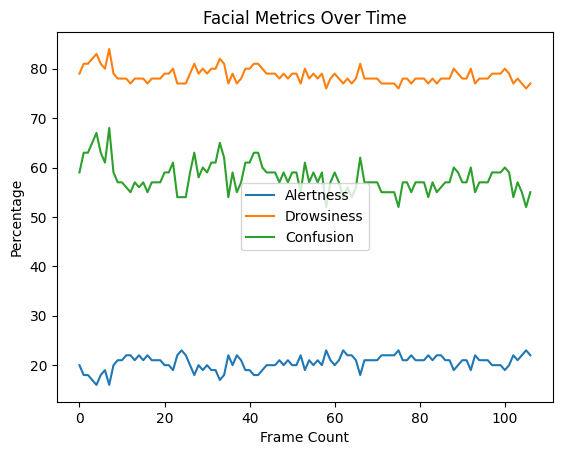

In [58]:
import cv2
import dlib
import numpy as np
import mediapipe as mp
import pandas as pd
import time
import matplotlib.pyplot as plt

# Load face detector & landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Initialize Mediapipe Hands for gesture recognition
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.7)
mp_draw = mp.solutions.drawing_utils

# Data storage
data_records = []

def calculate_metrics(landmarks):
    """Analyze facial features and return percentage-based states."""
    
    # Eye openness (difference between upper & lower eyelids)
    left_eye_openness = landmarks.part(38).y - landmarks.part(40).y
    right_eye_openness = landmarks.part(44).y - landmarks.part(46).y
    avg_eye_openness = (left_eye_openness + right_eye_openness) / 2
    
    # Eyebrow movement (distance between eyebrow and eye center)
    left_eyebrow_height = landmarks.part(21).y - landmarks.part(27).y
    right_eyebrow_height = landmarks.part(22).y - landmarks.part(27).y
    avg_eyebrow_height = (left_eyebrow_height + right_eyebrow_height) / 2
    
    # Mouth openness (difference between upper & lower lips)
    mouth_open = landmarks.part(66).y - landmarks.part(62).y
    
    # Normalize values
    eye_score = np.clip((avg_eye_openness - 3) * 10, 0, 100)
    eyebrow_score = np.clip((avg_eyebrow_height + 10) * 5, 0, 100)
    mouth_score = np.clip(mouth_open * 5, 0, 100)
    
    # Assign percentages
    alertness = eye_score * 0.5 + eyebrow_score * 0.3 + (100 - mouth_score) * 0.2
    drowsiness = (100 - eye_score) * 0.5 + (100 - eyebrow_score) * 0.3 + mouth_score * 0.2
    # engagement = eyebrow_score * 0.6 + mouth_score * 0.4
    confusion = (100 - eyebrow_score) * 0.6 + mouth_score * 0.4
    
    return {
        "Alertness": int(alertness),
        "Drowsiness": int(drowsiness),
        # "Engagement": int(engagement),
        "Confusion": int(confusion)
    }

def detect_thumbs_up(hand_landmarks):
    """Detects if a thumbs-up gesture is present."""
    if hand_landmarks:
        for hand in hand_landmarks:
            landmarks = hand.landmark
            
            # Thumb tip (landmark 4) should be higher than index finger MCP (landmark 5)
            if landmarks[4].y < landmarks[5].y:
                return True
    return False

# Start webcam
cap = cv2.VideoCapture(0)
thumbs_up_detected = False
start_time = time.time()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    # Hand detection
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_frame)

    for face in faces:
        landmarks = predictor(gray, face)
        metrics = calculate_metrics(landmarks)
        
        # Store data
        data_records.append(metrics)
        
        # Display percentages on the screen
        y_offset = 40
        for key, value in metrics.items():
            cv2.putText(frame, f"{key}: {value}%", (20, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
            y_offset += 30

    # Check for thumbs-up gesture
    if detect_thumbs_up(results.multi_hand_landmarks):
        thumbs_up_detected = True
        break  # Stop recording

    # Show frame
    cv2.imshow("Facial Tracking with Metrics", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Generate report and graphs if thumbs-up was detected
if thumbs_up_detected:
    df = pd.DataFrame(data_records)
    
    # Calculate averages
    avg_metrics = df.mean().to_dict()
    report = f"📊 **Session Report** 📊\n\n"
    report += f"🕒 Duration: {int(time.time() - start_time)} seconds\n\n"
    for key, value in avg_metrics.items():
        report += f"🔹 {key}: {round(value, 2)}%\n"
    
    # Save report
    with open("session_report.txt", "w", encoding="utf-8") as file:
        file.write(report)
    
    # Generate graphs
    plt.figure(figsize=(10, 5))
    df.plot(kind='line', title='Facial Metrics Over Time')
    plt.xlabel('Frame Count')
    plt.ylabel('Percentage')
    plt.legend()
    plt.savefig("metrics_graph.png")
    
    print("\n✅ **Recording Stopped: Thumbs Up Detected!**\n")
    print(report)
    print("📈 Graph saved as 'metrics_graph.png'")


In [8]:
import numpy as np

def calculate_iou(pred_points, gt_points):
    """
    Calculate the Intersection over Union (IoU) for facial landmark detection.
    
    Parameters:
    pred_points: List of (x, y) tuples for predicted landmarks.
    gt_points: List of (x, y) tuples for ground truth landmarks.

    Returns:
    IoU value (0 to 1)
    """
    pred_x = [p[0] for p in pred_points]
    pred_y = [p[1] for p in pred_points]
    
    gt_x = [g[0] for g in gt_points]
    gt_y = [g[1] for g in gt_points]

    # Compute bounding boxes around landmarks
    pred_bbox = (min(pred_x), min(pred_y), max(pred_x), max(pred_y))
    gt_bbox = (min(gt_x), min(gt_y), max(gt_x), max(gt_y))

    # Compute intersection
    xA = max(pred_bbox[0], gt_bbox[0])
    yA = max(pred_bbox[1], gt_bbox[1])
    xB = min(pred_bbox[2], gt_bbox[2])
    yB = min(pred_bbox[3], gt_bbox[3])
    
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute individual and union areas
    pred_area = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    gt_area = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    # Compute IoU
    iou = interArea / float(pred_area + gt_area - interArea)

    return iou

# Example usage (Replace with actual facial landmark data)
pred_landmarks = [(467, 625), (474, 648), (483, 676), (497, 710)]
gt_landmarks = [(470, 630), (475, 650), (485, 680), (500, 715)]

iou_score = calculate_iou(pred_landmarks, gt_landmarks)
print(f"IoU Score: {iou_score:.4f}")


IoU Score: 0.7347


In [9]:
import cv2
import dlib
import numpy as np

# Load DLIB’s face detector and 68-point landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Load image and convert to grayscale
image = cv2.imread("me papa bday.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = detector(gray)

# Example: Define Ground Truth (manually labeled)
gt_bbox =  [433, 460, 817, 802]

for face in faces:
    # Get detected bounding box (DLIB)
    pr_bbox = [face.left(), face.top(), face.right(), face.bottom()]

    # Calculate IoU
    xA = max(gt_bbox[0], pr_bbox[0])
    yA = max(gt_bbox[1], pr_bbox[1])
    xB = min(gt_bbox[2], pr_bbox[2])
    yB = min(gt_bbox[3], pr_bbox[3])

    # Compute intersection and union
    intersection = max(0, xB - xA) * max(0, yB - yA)
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    area_pr = (pr_bbox[2] - pr_bbox[0]) * (pr_bbox[3] - pr_bbox[1])
    union = area_gt + area_pr - intersection

    iou = intersection / union if union > 0 else 0
    print(f"IoU: {iou:.4f}")

    # Draw detected bounding box
    cv2.rectangle(image, (pr_bbox[0], pr_bbox[1]), (pr_bbox[2], pr_bbox[3]), (0, 255, 0), 2)

    # Draw landmarks
    landmarks = predictor(gray, face)
    for n in range(68):
        x, y = landmarks.part(n).x, landmarks.part(n).y
        cv2.circle(image, (x, y), 2, (0, 0, 255), -1)

# Show output
cv2.imshow("Face Detection & IoU", image)
cv2.waitKey(0)
cv2.destroyAllWindows()


IoU: 0.8930


In [10]:
import cv2

# Load Image
image_path = "me papa bday.jpg"  # Change to your image path
img = cv2.imread(image_path)

# Initialize variables
roi = None

# Mouse callback function to select ROI
def select_roi(event, x, y, flags, param):
    global roi
    if event == cv2.EVENT_LBUTTONDOWN:
        roi = [(x, y)]  # Start point
    elif event == cv2.EVENT_LBUTTONUP:
        roi.append((x, y))  # End point
        cv2.rectangle(img, roi[0], roi[1], (255, 0, 0), 2)
        cv2.imshow("Select Ground Truth", img)

# Create Window
cv2.namedWindow("Select Ground Truth")
cv2.setMouseCallback("Select Ground Truth", select_roi)

# Show Image
print("📌 Drag to select the ground truth bounding box, then press ENTER or ESC")
cv2.imshow("Select Ground Truth", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Print Corrected Ground Truth Coordinates
if roi:
    x_min, y_min = roi[0]
    x_max, y_max = roi[1]
    print(f"✅ Ground Truth Bounding Box: [{x_min}, {y_min}, {x_max}, {y_max}]")
else:
    print("❌ No bounding box selected!")


📌 Drag to select the ground truth bounding box, then press ENTER or ESC
❌ No bounding box selected!


In [11]:
import cv2
import numpy as np

# Load the image
image_path = "me papa bday.jpg"  # Change if needed
image = cv2.imread(image_path)
landmarks = []  # Store manually clicked points

def click_event(event, x, y, flags, param):
    """Callback function to capture mouse clicks for landmark selection."""
    if event == cv2.EVENT_LBUTTONDOWN:
        landmarks.append((x, y))  # Store (x, y) coordinates
        cv2.circle(image, (x, y), 3, (0, 0, 255), -1)  # Draw red dot
        cv2.imshow("Annotate Landmarks", image)

# Display the image and allow annotation
cv2.imshow("Annotate Landmarks", image)
cv2.setMouseCallback("Annotate Landmarks", click_event)

print("📌 Click on facial landmarks in the image. Press 'q' when done.")

# Wait for user input
while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):  # Press 'q' to exit
        break

cv2.destroyAllWindows()

# Convert landmarks to NumPy array
gt_landmarks = np.array(landmarks)
print("Manually Annotated Landmarks:")
print(gt_landmarks)

# Save landmarks
np.save("manual_landmarks.npy", gt_landmarks)


📌 Click on facial landmarks in the image. Press 'q' when done.
Manually Annotated Landmarks:
[]


In [12]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Ground Truth Landmarks (x, y coordinates)
gt_landmarks = np.array([
    [100, 100],
    [150, 100],
    [125, 150],
    [110, 180],
    [140, 180]
])

# Predicted Landmarks (x, y coordinates)
pred_landmarks = np.array([
    [102, 98],  
    [148, 102], 
    [127, 148],  
    [112, 182],  
    [138, 178]  
])

# Compute MSE for x and y coordinates
mse = mean_squared_error(gt_landmarks, pred_landmarks)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Mean Squared Error (MSE): 4.0000
Root Mean Squared Error (RMSE): 2.0000


In [13]:
import cv2
import numpy as np

# Load image
image_path = "me papa bday.jpg"  # Update with your image path
image = cv2.imread(image_path)
clone = image.copy()

# List to store manual landmarks
manual_landmarks = []
feature_names = ["Left Eyebrow", "Right Eyebrow", "Left Eye", "Right Eye", "Mouth"]
feature_points = [5, 5, 6, 6, 20]  # Corrected total: 42 points

current_feature = 0
current_points = 0

def click_event(event, x, y, flags, param):
    global current_points, current_feature, manual_landmarks

    if event == cv2.EVENT_LBUTTONDOWN:
        manual_landmarks.append([x, y])
        cv2.circle(clone, (x, y), 3, (0, 0, 255), -1)  # Red dot for annotation
        cv2.imshow("Manual Annotation", clone)

        current_points += 1

        # Move to the next feature when enough points are marked
        if current_points == feature_points[current_feature]:
            current_feature += 1
            current_points = 0
            if current_feature < len(feature_names):
                print(f"➡️ Now annotate: {feature_names[current_feature]}")
            else:
                print("✅ Annotation complete! Saving landmarks...")
                np.save("manual_landmarks.npy", np.array(manual_landmarks))
                cv2.destroyAllWindows()

print(f"🖱️ Click on: {feature_names[current_feature]}")
cv2.imshow("Manual Annotation", image)
cv2.setMouseCallback("Manual Annotation", click_event)
cv2.waitKey(0)
cv2.destroyAllWindows()



🖱️ Click on: Left Eyebrow


In [ ]:
print("Manual Landmarks Shape:", manual_landmarks.shape)


In [ ]:
for (gt, pred, error) in zip(gt_feature, pred_feature, errors):
    color = (0, 255, 0) if error < 10 else (0, 255, 255) if error < 30 else (0, 0, 255)
    cv2.circle(image, tuple(pred), 3, color, -1)  # Color-coded error representation
    cv2.line(image, tuple(gt), tuple(pred), (255, 0, 0), 1)


In [ ]:
cv2.rectangle(image, (face.left(), face.top()), (face.right(), face.bottom()), (255, 0, 255), 2)


In [ ]:
import cv2
import numpy as np

# Load image
image = cv2.imread("me papa bday.jpg")

# Load landmarks
manual_landmarks = np.load("manual_landmarks.npy")


# Define landmark indices for features
FEATURES = {
    "Left Eyebrow": [0, 1],
    "Right Eyebrow": [2, 3],
    "Left Eye": [4, 5],
    "Right Eye": [6, 7]
}

# Draw and annotate errors
for feature, indices in FEATURES.items():
    gt_feature = manual_landmarks[indices]  # Ground Truth
    pred_feature = model_landmarks[indices]  # Model Prediction
    errors = np.linalg.norm(gt_feature - pred_feature, axis=1)

    for (gt, pred, error) in zip(gt_feature, pred_feature, errors):
        color = (0, 255, 0) if error < 50 else (0, 255, 255) if error < 150 else (0, 0, 255)  # Green-Yellow-Red

        # Draw ground truth
        cv2.circle(image, tuple(gt), 4, (0, 255, 0), -1)  # Green

        # Draw predicted point
        cv2.circle(image, tuple(pred), 4, color, -1)  # Red/Yellow

        # Draw error line
        cv2.line(image, tuple(gt), tuple(pred), (255, 0, 0), 2)

        # Display error value
        text_position = (pred[0] + 10, pred[1] - 10)
        cv2.putText(image, f"{error:.2f}", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

# Show result
cv2.imshow("Landmark Error Visualization", image)
cv2.waitKey(0)
cv2.destroyAllWindows()
